In [2]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
from importlib import reload
import setGPU

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [34]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((1*10e4//batch_size)*batch_size)

In [35]:
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepr.prepare_data(filename_bg,train_set_size,0,train_set_size+1)

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e3//batch_size)*batch_size)
_,_, particles_bg_valid, A_bg_valid, A_tilde_bg_valid = prepr.prepare_data(filename_bg,valid_set_size,0,valid_set_size+1)

/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 196521
Number of constituents (nodes) = 50
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:56: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


Number of jets = 19625
Number of constituents (nodes) = 50
Number of features = 3


In [7]:
#BG test
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg_valid,5000,train_set_size+1,train_set_size+5000)


Number of jets = 9840
Number of constituents (nodes) = 50
Number of features = 3


In [8]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


In [14]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(9984, 50, 3) (9984, 50, 50) (9984, 50, 50)


# Plot features

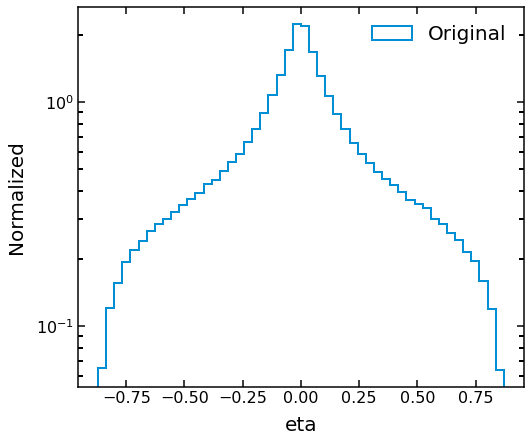

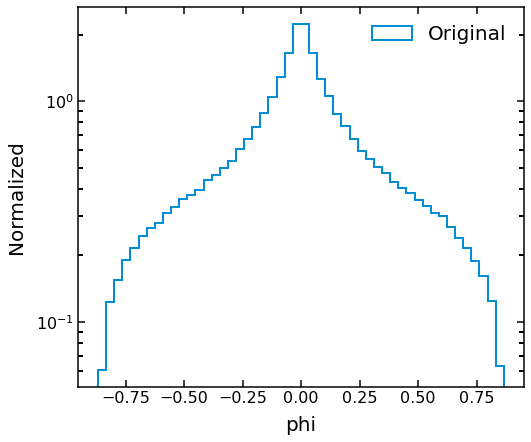

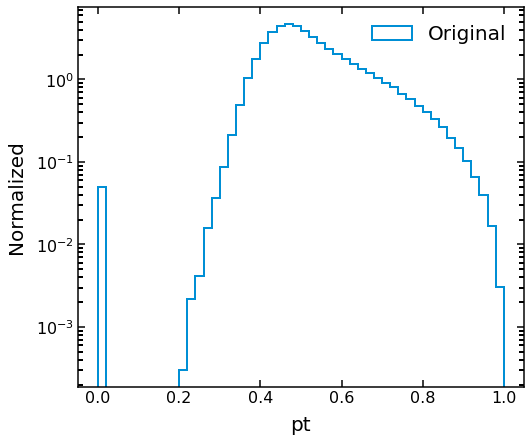

In [9]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Original', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

# GCN VAE

In [10]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [36]:
import models.losses as losses
reload(losses)
import models.layers as layers
reload(layers)
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [37]:
gcnvae = models.GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=8,
                                          beta_kl=10,kl_warmup_time=5)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True)

#gcnae = models.GCNAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=5)
#gcnae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True)


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 50, 50)]     0                                            
__________________________________________________________________________________________________
graph_convolution_bias_18 (Grap (None, 50, 6)        24          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_bias_19 (Grap (None, 50, 2)        14          graph_convolution_bia

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_latent_space (Inp [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 50)           450         decoder_input_latent_space[0][0] 
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 100)          5100        dense_26[0][0]                   
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 50, 2)        0           dense_27[0][0]                   
______________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(gcnvae, show_shapes=True)

In [40]:
custom_callback = models.KLWarmupCallback()

checkpoint_filepath = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/weights_gcnvae.{epoch:02d}-{val_loss:.3f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=2),
             custom_callback],
           # model_checkpoint_callback] 
gcnvae.fit(particles_bg, A_tilde_bg, epochs=100, batch_size=256, 
           validation_data = ((particles_bg_valid, A_tilde_bg_valid)), callbacks=callbacks) 


Epoch 1/100
391/391 [==============================] - 14s 35ms/step - loss: 0.8925 - loss_reco: 0.4420 - loss_latent: 0.2252 - beta_kl_warmup: 0.2000 - val_loss: 0.3399 - val_loss_reco: 0.3396 - val_loss_latent: 1.2184e-04mup - ETA: 3s - loss: 1.1013 - loss_reco: 0.4731 - loss_latent: 0.3141 - be
Epoch 2/100
391/391 [==============================] - 12s 29ms/step - loss: 0.2750 - loss_reco: 0.2747 - loss_latent: 6.3378e-05 - beta_kl_warmup: 0.4000 - val_loss: 0.2304 - val_loss_reco: 0.2303 - val_loss_latent: 2.6690e-05
Epoch 3/100
391/391 [==============================] - 13s 34ms/step - loss: 0.2091 - loss_reco: 0.2090 - loss_latent: 1.2734e-05 - beta_kl_warmup: 0.6000 - val_loss: 0.1998 - val_loss_reco: 0.1997 - val_loss_latent: 5.5812e-06A: 9s - loss: 0.2235 - loss_reco: 0.223 - ETA: 8s - loss: 0.2205 - loss_reco: 0.2203 - loss_latent: 2.1134e-05 - beta_kl_warmup: 0. - ETA: 8s - loss: 0.2203 - loss_reco: 0.2202 - loss_latent: 2.1003e-05 - be - ETA: 7s - loss: 0.2192 - loss_reco:


In [41]:

def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)




In [ ]:
loaded_1 = tf.keras.models.load_model(
    "output_model_saved_006", custom_objects={"GCNVariationalAutoEncoder": models.GCNVariationalAutoEncoder}
)


In [43]:
#Predict

#model = loaded_1
model = gcnvae
#model = gcnae


features_out_bg_test, z,_,_ = model((particles_bg_test, A_tilde_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss_manual(particles_bg_test.astype('float32'),features_out_bg_test)

features_out_sig, z,_,_ = model((particles_sig, A_tilde_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss_manual(particles_sig.astype('float32'),features_out_sig)

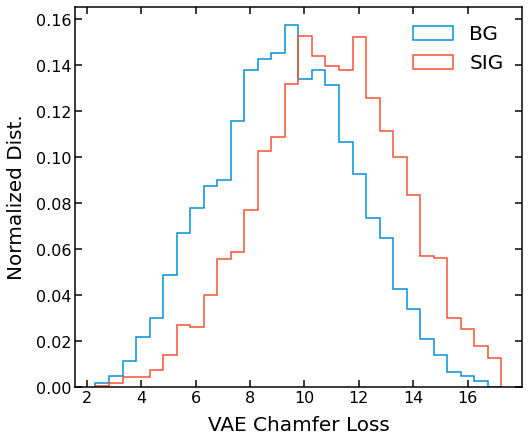

In [44]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

In [15]:
print(np.quantile(loss_bg,0.8),np.quantile(loss_signal,0.8))

12.605500221252441 13.990795516967774


In [29]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../vande/')))
sys.path.append(os.path.abspath(os.path.join('../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../sarewt/')))

In [30]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

In [45]:
#neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
#pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_signal.tolist()]

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


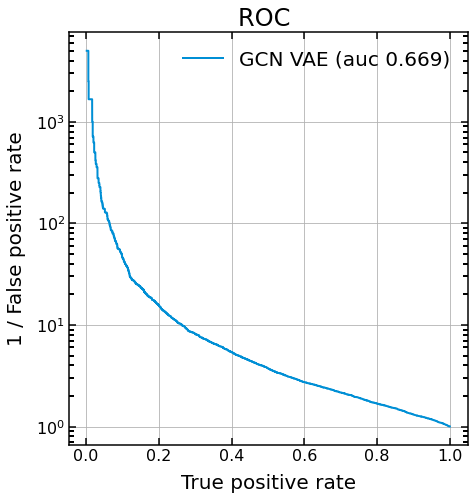

[0.6694185]

In [46]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae//figs/',log_x=False )



# Plot features , only makes sense for AE

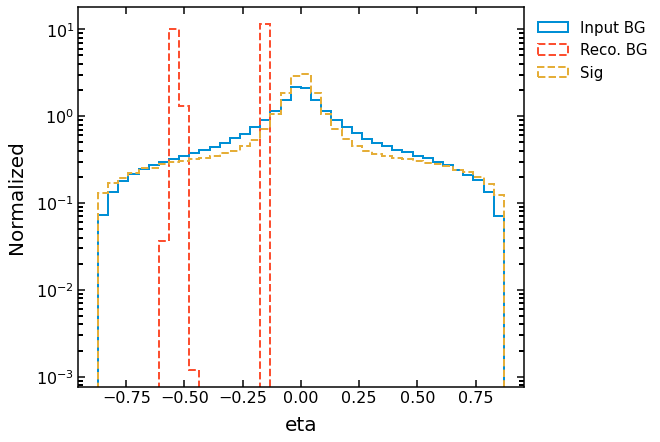

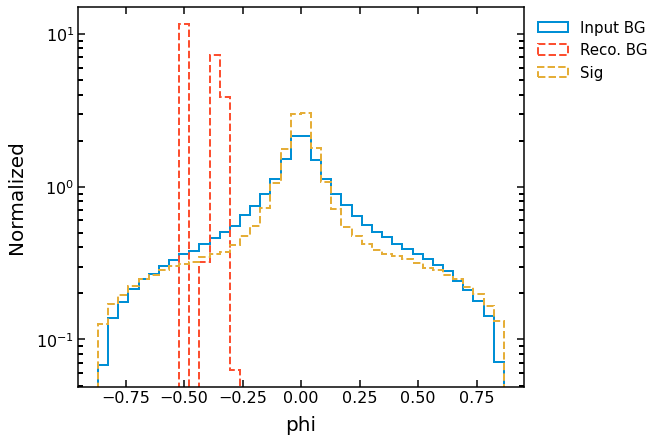

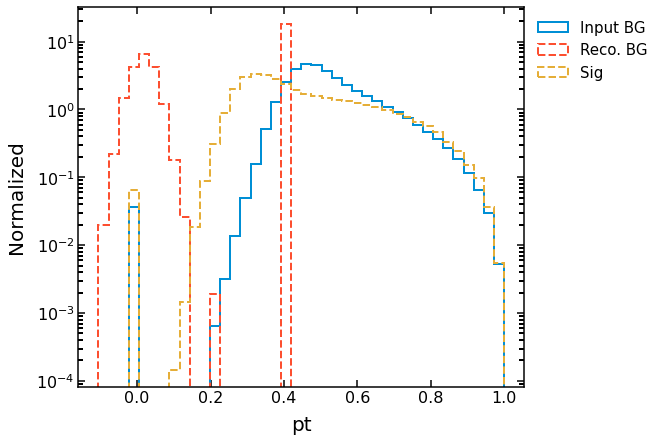

In [33]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(features_out_bg_test[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(features_out_bg_test[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(features_out_bg_test[:,:,i].flatten(), bins=bins,label='Reco. BG',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(particles_sig[:,:,i].flatten(), bins=bins,label='Sig ',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    plt.show()